AIM: GENERATE LYRICS

In [ ]:
import pandas as p
import matplotlib.pyplot as m
import numpy as np
import re


In [ ]:
df = p.read_csv("/content/01-taylor_swift.csv")
df.head(10)

In [ ]:
df["length"] = df.lyric.str.len()

In [ ]:
df.describe()

,track_n,line,length
count,609.000000,609.000000,609.000000
mean,7.991790,22.095238,33.630542
std,4.394404,13.619505,12.694271
min,1.000000,1.000000,4.000000
25%,4.000000,11.000000,24.000000
50%,8.000000,21.000000,32.000000
75%,12.000000,32.000000,42.000000
max,15.000000,55.000000,78.000000


In [ ]:
df.shape

<BarContainer object of 609 artists>

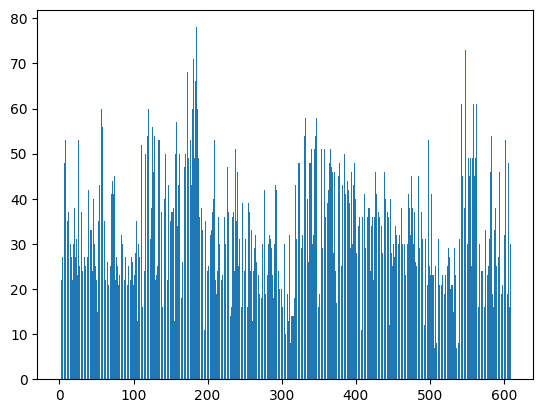

In [ ]:
m.bar([i for i in range(1,610)],df["length"])

**The length of lyrics is good we do not need other columns**

In [ ]:
df.drop(["album_name","track_title","track_n","line"],axis= 1,inplace=True)

**LET'S DO PREPROCESSING OF COLUMN LYRIC**


1.   remove stopwords
2.   remove punctuations

1.   lowercase





In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def preprocess(ly):
  ly = ly.lower().split(" ")
  res = ""
  for i in ly:
    if i in set(stopwords.words('english')):
      pass
    else:
      res = res + " " + i

  res = res.strip()

  return res



In [ ]:
df["lyric"] = df["lyric"].apply(lambda x : preprocess(x))

In [ ]:
df.head(5)

,lyric,length
0,said way blue eyes shined,35
1,put georgia stars shame night,43
2,"said, ""that's lie""",22
3,boy chevy truck,27
4,tendency gettin' stuck,36


In [ ]:
def remove_punc(text):
  text = "".join(text)
  res1= re.sub("r[^a-zA-z]","",text)

  return res1



In [ ]:
df["lyric"] = df["lyric"].apply(lambda x : remove_punc(x))

In [ ]:
df.head(5)

,lyric,length
0,said way blue eyes shined,35
1,put georgia stars shame night,43
2,"said, ""that's lie""",22
3,boy chevy truck,27
4,tendency gettin' stuck,36


**DOING LEMMATIZATION**

In [ ]:
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def lemmati(x):
  lemma = WordNetLemmatizer()
  res = ""
  for i in x.split():
    res = res + " " + lemma.lemmatize(i)

  res = res.strip()
  return res

In [ ]:
df.lyric= df.lyric.apply(lambda x : lemmati(x))

In [ ]:
df.head(15)

,lyric,length
0,said way blue eye shined,35
1,put georgia star shame night,43
2,"said, ""that's lie""",22
3,boy chevy truck,27
4,tendency gettin' stuck,36
5,back road night,22
6,right beside summer long,48
7,time woke find summer gone,53
8,think tim mcgraw,29
9,hope think favorite song,33


**Wordcloud**

In [ ]:
from wordcloud import WordCloud
joinedword = " ".join(df["lyric"])

In [ ]:
wrdc = WordCloud(width = 400,height = 400,background_color="red").generate(joinedword)

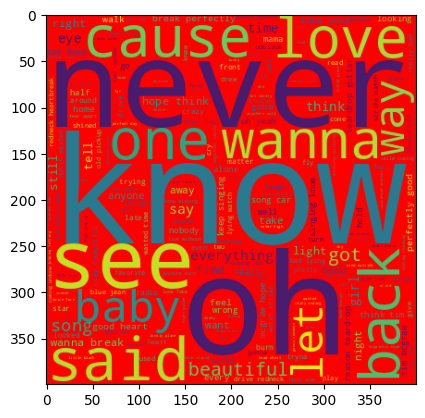

In [ ]:
m.imshow(wrdc)

**MAPPING CHARACTERS INTO DICTIONARY**

In [ ]:
jw = joinedword.split(" ")
uniquechar = sorted(set(jw))
print(uniquechar)

In [ ]:
char_dic = {}
count = 0
for i in uniquechar:
  char_dic[i] = count
  count+=1


num_dic = {}
for key,val in char_dic.items():
  num_dic[val] = key


print(char_dic)
print(num_dic)


In [ ]:
features = []
targets = []
for i in range(0,len(joinedword)-20):
  f= joinedword[i:i+20]
  t = joinedword[i+20]
  flis = []
  for char in f:
    flis.append(char_dic[char])

  features.append(flis)
  targets.append(char_dic[t])

In [ ]:
from keras.utils import to_categorical
X = (np.reshape(features, (len(targets), 20, 1)))/ float(len(uniquechar))
y= to_categorical(targets)

In [ ]:
y.shape

In [ ]:
X.shape

**MODEL**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
model = Sequential()
model.add(LSTM(37, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training
model.compile(loss='categorical_crossentropy', optimizer="adam")

#Model's Summary
model.summary()


In [ ]:
fitted_model = model.fit(X, y, batch_size=128, epochs=100,verbose=1)

**NEW MODEL**

In [ ]:
nm= Sequential()

In [ ]:
from keras.layers import Bidirectional

In [ ]:
nm.add(LSTM(512 , input_shape=(20,1)))
nm.add(Dense(256,activation = "relu"))
nm.add(Dense(37 , activation = "softmax"))



In [ ]:
nm.compile(loss='categorical_crossentropy', optimizer="adam")

In [ ]:
fitted_nm = nm.fit(X,y,epochs =10 , verbose=1)

**PREDICTION**

In [ ]:
default = "see you in time i want you there"

In [ ]:
chr1 = [char_dic[i] for i in default]
ex1 = np.reshape(chr1 , (len(chr1),1))
pred= model.predict(ex1)[0]
# pred = np.max(pred)
# print(pred)


1/1 [==============================] - 0s 30ms/step


In [ ]:
prediction = np.log(pred) / 0.5
exp_preds = np.exp(prediction)
exp_preds = exp_preds+0.453
prediction = exp_preds / np.sum(exp_preds)
probas = np.random.multinomial(1, prediction, 1)
index = np.argmax(prediction)

In [ ]:
def predict_seq(default , x =30):
  given = ""
  for i in range(x):
    chr1 = [char_dic[i] for i in default]
    ex1 = np.reshape(chr1 , (len(chr1),1))
    pred= model.predict(ex1,verbose = 0)[0]
    p = np.log(pred)/0.43
    p= p+ 5
    p = np.exp(p)
    p = p// np.sum(p)
    p1  = np.random.multinomial(1, p, 1)

    index = np.argmax(p)
    given+= num_dic[index]
    # print(num_dic , given)
    default = default[1:]+given

  return given


In [ ]:
# print(predict_seq(default))

print(predict_seq("boy chevy truck my love hate or love me but i want you"))


In [ ]:
def pred2_seq(default, x =30):
  given1 = ""
  for i in range(x):
    chr1 = [char_dic[i] for i in default]
    ex1 = np.reshape(chr1 , (len(chr1),1))
    pred= model.predict(ex1,verbose = 0)[0]
    p = np.log(pred)/0.43
    p= p+ 5
    p = np.exp(p)
    p = p// np.sum(p)
    p1  = np.random.multinomial(1, p, 1)
    index = np.argmax(p1)
    given1+= num_dic[index]
    # print(num_dic , given)
    default = default[1:]+given1
  return given1



In [ ]:
print(pred2_seq("boy chevy truck my love hate or love me but i want you"))


zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz


**EAVALUATION OF BOTH MODEL**

In [ ]:
m.plot(fitted_model.epoch,fitted_model.history["loss"])

In [ ]:
m.plot(fitted_nm.epoch , fitted_nm.history['loss'])

In [ ]:
model.save("lyrics_generator_model1")

In [ ]:
nm.save("lyrics_generator_model2")